<h1><center>FEATURE EXTRACTION</center></h1>

# Imports and image extraction from DICOM

In [6]:
# all import statements
import numpy as np
import pandas as pd
import pydicom as pyd
import os
import matplotlib.pyplot as plt
import mudicom

from os.path import dirname, join
from pydicom.data import get_testdata_files
from pydicom.filereader import read_dicomdir
from PIL import Image

from scipy.misc import imresize
from scipy.signal import convolve2d
import scipy
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from numpy import newaxis

In [7]:
PATH = 'data/stage_2_train_images/'

lstFilesDCM = []  
for dirName, subdirList, fileList in os.walk(PATH):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

len(lstFilesDCM)

dcm_40 = []
for img in range(40):
    dcm_40.append(lstFilesDCM[img])

dcm_np = []
pat_ids = []
for dcm in dcm_40:
    pat_ids.append(dcm.split('/')[2].split('.')[0])
    img = mudicom.load(dcm)
    img = img.image
    img = img.numpy
    dcm_np.append(img)


def show(img, title=None):
    plt.imshow(img, cmap=plt.cm.bone)
    if title is not None: plt.title = title

def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap=plt.cm.bone)

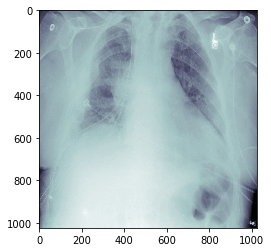

In [8]:
show(dcm_np[2])

# Histogram Equalization

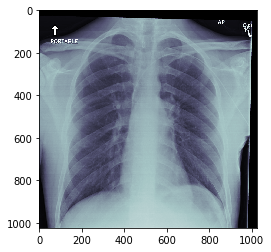

In [5]:
image = dcm_np[5]; show(image)

In [100]:
import cv2
from skimage import img_as_float
from skimage import exposure

In [96]:
# x = cv2.imread(image)
# # image_eqH = cv2.equalizeHist(image)

**Contrast Stretching**

In [10]:
p2, p98 = np.percentile(image, (2, 98))

In [11]:
img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

**Equalization**

In [12]:
img_eq = exposure.equalize_hist(image)

**Adaptive Equalization**

In [14]:
# img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

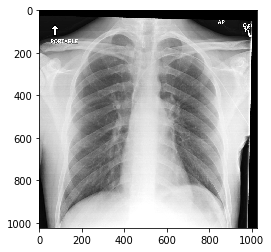

In [16]:
plt.imshow(img_rescale, cmap='gray')

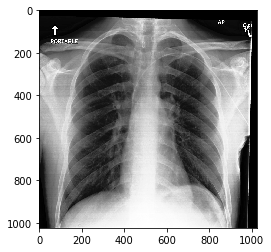

In [17]:
plt.imshow(img_eq, cmap='gray')

**Adaptive Equalization**


In [23]:

# img_adapteq = exposure.equalize_adapthist(image)

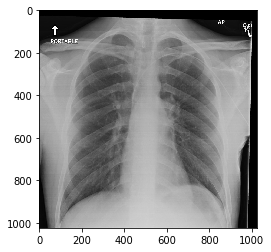

In [24]:
plt.imshow(image, cmap='gray')

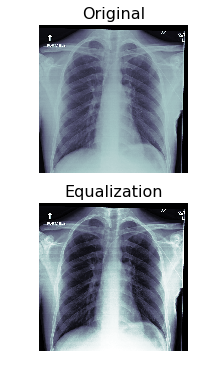

In [26]:
plots([image, img_eq], titles=['Original', 'Equalization'])

In [48]:
# import numpy as np

# def dicom_to_rgb(img,bt,wt):

#     # enforce boundary conditions
#     img = np.clip(img,bt,wt)

#     # linear transformation
#     # multiplicative
#     img = np.multiply(img,-255/(wt-bt)).astype(np.int)
#     # additive
#     img += 255

#     # stack thrice on the last axis for R G B
#     rgb_img = np.stack([img]*3,axis=-1)

#     return rgb_img


# #     pixels = 512
# #     img = np.random.randint(-2000,2000,pixels**2).reshape(pixels,pixels)
# #     bt = 0
# #     wt = 1400

# #     rgb = dicom_to_rgb(img,bt,wt)

In [40]:
# x = dicom_to_rgb(image, 10, 200)

In [49]:
# show(x)

# Discrete Wavelet Decomposition

In [50]:
import pywt

In [82]:
coeffs2 = pywt.dwt2(img_eq, 'bior1.3')

In [83]:
len(coeffs2)

2

In [84]:
LL, (LH, HL, HH) = coeffs2

In [85]:
LL.shape

(514, 514)

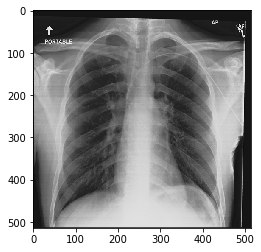

In [94]:
plt.imshow(LL, cmap='gray')

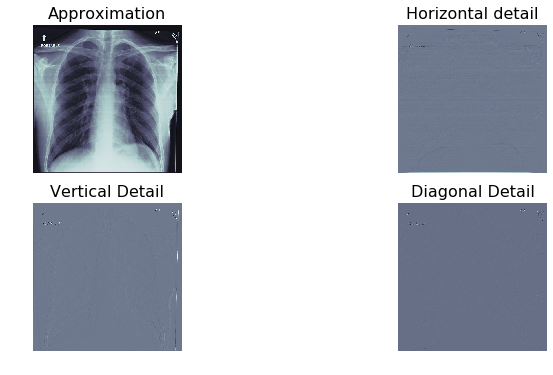

In [87]:
plots([LL, LH, HL, HH], titles=['Approximation', 'Horizontal detail', 'Vertical Detail', 'Diagonal Detail'])

In [73]:
from pywt import wavedec
coeffs = wavedec(image, 'db1', level=1)

In [74]:
len(coeffs)

2

In [76]:
cA2, cD2 = coeffs

In [77]:
cD1.shape

(1024, 512)

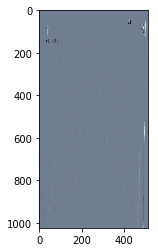

In [78]:
show(cD1)

In [95]:
# x = pywt.downcoef('a', image,'db1', mode='symmetric', level=1)

# WaterShed Segmentation

In [97]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max


In [109]:
distance = ndi.distance_transform_edt(image)

In [129]:
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)), labels=image)

In [130]:
markers = ndi.label(local_maxi)[0]

In [131]:
labels = watershed(-distance, markers, mask=image)

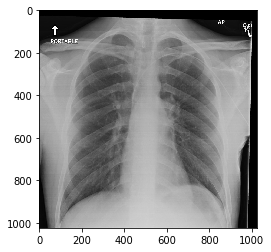

In [132]:
plt.imshow(image, cmap=plt.cm.gray)

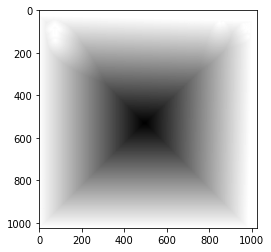

In [133]:
plt.imshow(-distance, cmap=plt.cm.gray)

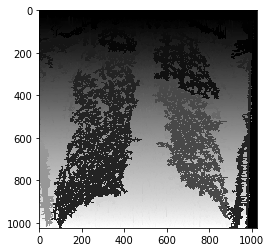

In [134]:
plt.imshow(labels, cmap=plt.cm.gray)

# Discrete Cosine Transform

In [139]:
xx = scipy.fftpack.idct(image)

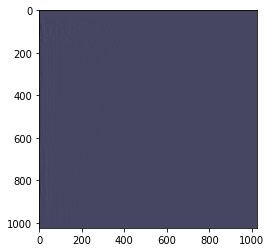

In [140]:
show(xx)

In [150]:
yy = scipy.fftpack.dct(image,1)

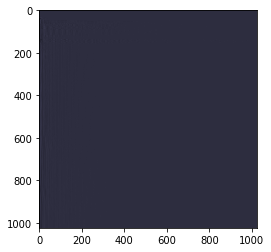

In [151]:
show(yy)

# Local Binary Pattern

In [152]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.color import label2rgb


Settings for LBP

In [153]:
radius = 3
n_points = 8 * radius

In [154]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image = image, bg_label=0, alpha = 0.5)

In [155]:
def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

In [156]:
image = image

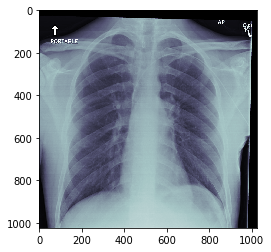

In [157]:
show(image)

In [159]:
lbp = local_binary_pattern(image, n_points, radius, 'uniform')

In [160]:
type(lbp)

numpy.ndarray

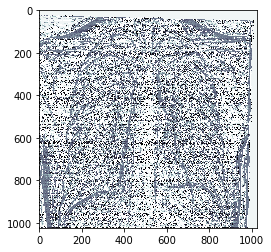

In [161]:
show(lbp)

In [162]:
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')

plot histograms of lbp of textures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/thevatsal/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


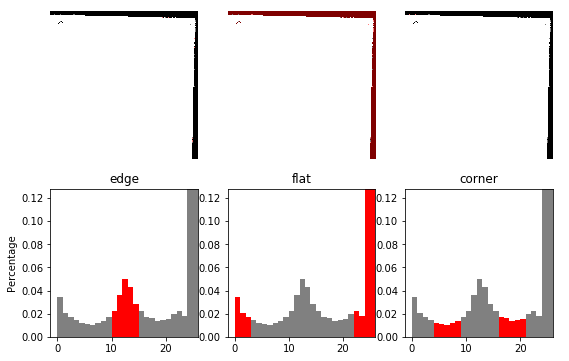

In [165]:
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()
titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w+1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4
i_34 = 3 * (n_points // 4)
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


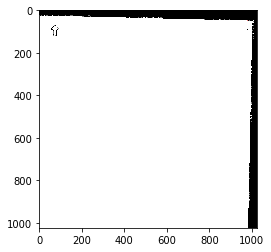

In [167]:
show(overlay_labels(image, lbp, corner_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


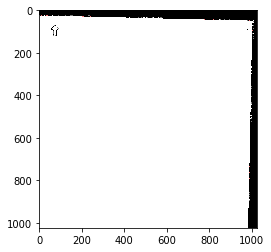

In [168]:
show(overlay_labels(image, lbp, edge_labels))

# Moment Invariants 

In [171]:
cv2.moments(image)

{'m00': 128298225.0,
 'm10': 64836775790.0,
 'm01': 71213745662.0,
 'm20': 42851607321492.0,
 'm11': 35971299989090.0,
 'm02': 49710342803742.0,
 'm30': 3.169368902062423e+16,
 'm21': 2.3587651317984264e+16,
 'm12': 2.510171401655926e+16,
 'm03': 3.8802825062121816e+16,
 'mu20': 10085701987706.36,
 'mu11': -17270083903.4375,
 'mu02': 10182145346512.773,
 'mu30': -155612503758108.0,
 'mu21': -180284613200948.0,
 'mu12': -726925900686.0,
 'mu03': -93092065310536.0,
 'nu20': 0.0006127239207647014,
 'nu11': -1.0491876057956025e-06,
 'nu02': 0.0006185830223930871,
 'nu30': -8.346278466900013e-07,
 'nu21': -9.669567346666829e-07,
 'nu12': -3.898867922180925e-09,
 'nu03': -4.992994016395634e-07}

In [173]:
cv2.HuMoments(cv2.moments(image)).flatten()

array([ 1.23130694e-03,  3.87322504e-11,  6.44475815e-12,  2.85303411e-12,
       -4.10814090e-24,  3.31694768e-18, -1.15234839e-23])

#  Region Properties

In [6]:
import math
from skimage.measure import label, regionprops

In [14]:
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [57]:
thresh = threshold_otsu(image)

In [58]:
square(3)

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8)

In [59]:
bw = closing(image > thresh, square(2))

In [60]:
type(thresh)

numpy.float64

In [61]:
thresh

108.076171875

In [62]:
type(bw)

numpy.ndarray

In [63]:
bw.shape

(1024, 1024)

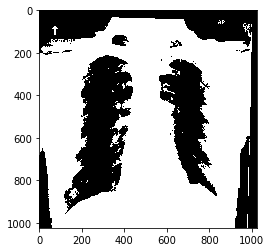

In [64]:
show(bw)

In [65]:
cleared = clear_border(bw)

In [66]:
type(cleared), cleared.shape

(numpy.ndarray, (1024, 1024))

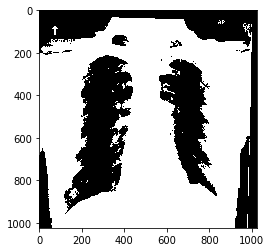

In [67]:
show(cleared)

In [68]:
label_img = label(cleared)
image_label_overlay = label2rgb(label_img, image = image)

In [69]:
type(label_img)

numpy.ndarray

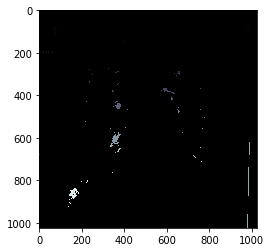

In [70]:
show(label_img)

In [71]:
type(image_label_overlay)

numpy.ndarray

In [74]:
import matplotlib.patches as mpatches

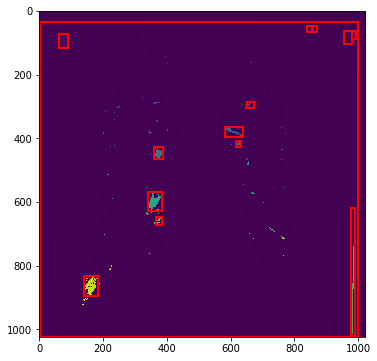

In [79]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label_img)

for region in regionprops(label_img):
    if region.area >=100:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill = False, edgecolor = 'red', linewidth = 2)
        
        ax.add_patch(rect)

In [86]:
xx = regionprops(label_img)

In [87]:
len(xx)

243

In [83]:
type(xx)

list

In [88]:
xx[1].area, xx[1].eccentricity

/usr/local/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


(146, 0.6831506196883235)

# GLCM and energy

In [90]:
from skimage.measure import shannon_entropy

In [97]:
shannon_entropy(image)

7.199189759712313

In [98]:
from skimage import io, color, img_as_ubyte
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics.cluster import entropy


In [105]:
from skimage import img_as_float
from skimage import img_as_uint
from skimage import img_as_int
# from skimage import img

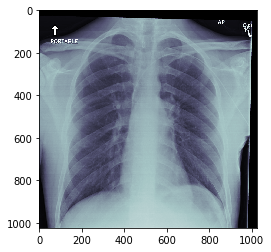

In [139]:
image = dcm_np[5]; show(image)

In [140]:
# image = (image//np.mean(image)) 

In [178]:
distance = [1,2,3]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

properties = ['energy', 'homogeneity']

image = img_as_ubyte(image.astype('int64'))

glcm = greycomatrix(image, distances=distance, angles=angles, symmetric=True, normed=True)

feats = np.hstack([greycoprops(glcm, prop).ravel() for prop in properties])

In [182]:
type(glcm)

numpy.ndarray

In [184]:
glcm.shape

(256, 256, 3, 4)

In [195]:
greycoprops(glcm, 'energy').flatten(), greycoprops(glcm, 'homogeneity').flatten(), greycoprops(glcm, 'contrast').flatten(), greycoprops(glcm, 'correlation').flatten()

(array([0.0725, 0.0681, 0.0713, 0.0681, 0.0686, 0.0681, 0.0682, 0.0681,
        0.0668, 0.065 , 0.0667, 0.065 ]),
 array([0.5467, 0.4408, 0.5107, 0.4417, 0.4219, 0.4408, 0.4085, 0.4417,
        0.3723, 0.3548, 0.376 , 0.355 ]),
 array([ 57.5056, 100.7415,  46.9375,  98.821 , 151.8247, 100.7415,
        103.8415,  98.821 , 228.2781, 233.9036, 143.2634, 230.8725]),
 array([0.9914, 0.9848, 0.993 , 0.9851, 0.9771, 0.9848, 0.9844, 0.9851,
        0.9655, 0.9646, 0.9784, 0.9651]))

In [179]:
entropy(image)

4.9900980842606195

In [180]:
np.set_printoptions(precision=4)

In [181]:
print(feats)

[0.0725 0.0681 0.0713 0.0681 0.0686 0.0681 0.0682 0.0681 0.0668 0.065
 0.0667 0.065  0.5467 0.4408 0.5107 0.4417 0.4219 0.4408 0.4085 0.4417
 0.3723 0.3548 0.376  0.355 ]


In [192]:
img_as_ubyte(dcm_np[0].astype('int64'))

/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.7/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


array([[105,   3,   0, ...,   0,   0,   0],
       [102,   1,   0, ...,   0,   0,   0],
       [ 97,   0,   0, ...,   0,   0,   0],
       ...,
       [  1,   1,   1, ..., 147, 170,  69],
       [  1,   1,   1, ..., 141, 165,  68],
       [  1,   1,   1, ..., 138, 161,  67]], dtype=uint8)

# SHIFT - Bag of Visual Words

In [3]:
# !pip3 install opencv-python==3.4.2.16        
# !pip3 install opencv-contrib-python==3.4.2.16        

import cv2

In [15]:
image = dcm_np[5]
image = image.astype('int64')
arr = np.uint8(image)


In [16]:
arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 4, 9, ..., 0, 0, 0],
       [0, 3, 6, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [13]:
sift = cv2.xfeatures2d.SIFT_create()

In [17]:
xx = sift.detect(arr)

In [18]:
type(xx)

list

In [19]:
len(xx)

261

In [25]:
img = cv2.drawKeypoints(arr, xx, arr)

In [21]:
# ??cv2.drawKeypoints

In [26]:
arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 4, 9, ..., 0, 0, 0],
       [0, 3, 6, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [28]:
img.shape

(1024, 1024, 3)

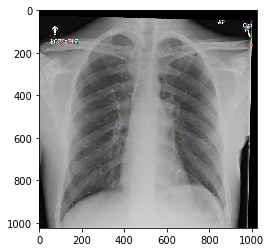

In [29]:
show(img)

In [32]:
xx[1].angle

57.962646484375

In [35]:
def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [37]:
from sklearn.neighbors import NearestNeighbors

data = image
keypoint, descriptors = features(np.uint8(data), sift)



In [43]:
len(keypoint)

261

In [41]:
len(descriptors), descriptors.shape

(261, (261, 128))

In [46]:
keypoint[3].

<function KeyPoint.overlap>

In [55]:
keypoint[1].pt

(28.582948684692383, 175.97959899902344)

In [56]:
keypoint[1].response

0.016984065994620323

In [57]:
keypoint[1].size

24.84852409362793

In [63]:
descriptors[1].shape

(128,)